[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)

# The Forward-Forward Algorithm with a Spiking Neural Network
### Tutorial written by Ethan Mulle and Abhinandan Singh


The following tutorial introduces how to implement the Forward-Forward algorithm proposed by Geoffrey Hinton into a spiking neural network (SNN).
> <cite> [Geoffrey Hinton. The Forward-Forward Algorithm: Some Preliminary
Investigations. 2022. arXiv: 2212.13345 [cs.LG].](https://arxiv.org/abs/2212.13345) </cite>

The Forward-Forward algorithm is inspired from a model of learning in the cortex, and offers a potentially low-power, local, backprop-free alternative to training a model. Of course, it is a challenging algorithm to scale up to more challenging tasks. But this is a good starting point to learn from.

For a comprehensive overview on how SNNs work, and what is going on under the hood, [then you might be interested in the snnTorch tutorial series available here.](https://snntorch.readthedocs.io/en/latest/tutorials/index.html)
The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

Install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install snntorch --quiet

In [2]:
import torch, torch.nn as nn
import snntorch as snn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## 1. The MNIST Dataset

### 1.1 Dataloading

- Set up dataloaders for the MNIST training and test datasets.

- Define a data transformation pipeline, and iterate over the first batch of the training loader to inspect the size of the data.

- The transformations include converting images to grayscale, transforming them to tensors, normalizing pixel values, and flattening the tensors.

In [3]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Grayscale, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader


transform = Compose([
    Grayscale(),
    ToTensor(),
    Normalize((0,), (1,)),
    Lambda(lambda x: torch.flatten(x))])

# Train set
mnist_train = MNIST('./data/', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

# Test set
mnist_test = MNIST('./data/', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_train, batch_size=128, shuffle=False)

## 2. Forward-Forward Algorithm Theory
The Forward-Forward algorithm is a learning rule inspired by Boltzmann machines and Noise Contrastive Estimation. The core idea is that each layer learns to tell apart *positive* examples (which we treat as '*good*') from *negative* examples (which we treat as '*bad*'. It works by replacing the forward and backward passes of backpropagation with two forward passes:
- The positive pass
- The negative pass. 

In the positive pass, a training example plus its label is fed through the network. Every layer computes a *goodness* measure (e.g., sum of squared neuron outputs). The weights are updated to *increase* goodness for that class's *correct* examples.  

In teh negative pass, we feed in *bad* examples. For example, the same input might be applied with the *wrong* class label. The network again measures the goodness in each layer, but now the weights are updated to decrease goodness. It is thought that over many iterations, each layer refines local filters or patterns that best distinguish each class from noise or other classes, without needing a global backpropagation signal. 

A high-level illustration of the algorithm is shown below.

<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial_forward-forward/forward-forward.png?raw=true' width="800">
</center>

Hinton proposes that goodness can be measured through a metric, such as the sum of the square of neural activities. The goal is to make the goodness to exceed some threshold value for real data and to fall below the thresholdfor negative data. In practice, Hinton applies the sigmoid function $\sigma$ to this deviation from the threshold $\theta$ such that the result can be interpreted as the probability that an input vector is positive (i.e., real):

\begin{equation}
    p(positive) = \sigma \left(\sum_j y_j^2 - \theta \right)
\end{equation}

where $y_j$ is the activity of hidden unit $j$.

## 3. Implementation
We follow and modify the Forward-Forward algorithm implementation found here:
> <cite> [Mohammad Pezeshki. pytorch_forward_forward. Github Repo January 2023.](https://github.com/mpezeshki/pytorch_forward_forward) </cite>

To do so, we must define both a layer and a network class.

### 3.1 Defining the Layer Class
- **LeakyLayer**: is a custom leaky integrate-and-fire layer with additional attributes. The class is designed to be used as a layer in a neural network.

- The **forward method**: defines the computations for a forward pass through the 'LeakyLayer'. The membrane potential is initialized, the input is normalized and weighted, and then passed through a leaky integrate-and-fire neuron, in order to return the resulting membrane potential. 

- The **train method**: performs a training loop over a specified number of epochs. It computes the goodness for positive and negative data, calculates the loss based on these goodness values, locally backpropagates the gradients, and updates the parameters using the optimizer. The method returns the membrane potentials for positive and negative data after training.

In [ ]:
from tqdm import tqdm
from torch.optim import Adam
import torch.nn.functional as F

class LeakyLayer(nn.Linear):

    def __init__(self, in_features, out_features, activation, bias=False):
        super().__init__(in_features, out_features, bias=bias)

        # Enable the choice between a spiking neuron and a standard artificial neuron (ReLU activation)
        if activation == "lif":
          self.activation = snn.Leaky(beta=0.8)
          self.lif = True
        else:
          self.activation = nn.ReLU()
          self.lif = False

        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 5.0
        self.num_epochs = 1000

    def forward(self, x):
        if self.lif == True:
          mem = self.activation.init_leaky() # initialize membrane potential

        x_direction = x / (torch.norm(x, p=2, dim=1, keepdim=True) + 1e-4) # normalize the input

        # Linear layer - not using nn.Linear(...) so we can define the update rule
        weighted_input = torch.mm(x_direction, self.weight.T.to(device)) # MatMul between normalized input and weight matrix

        if self.lif == True:
          spk, potential = self.activation(weighted_input, mem) # note: only one step in time. Wrap in a for-loop to iterate for longer.
        else:
          potential = self.activation(weighted_input)

        return potential  # to be used in subsequent layers or as the final output of the last layer

    def train(self, x_pos, x_neg):
        
        tot_loss = []  # store the loss values for each layer in each epoch
        for _ in tqdm(range(self.num_epochs), desc="Training LeakyLayer"):

            # Compute goodness
            g_pos = self.forward(x_pos).pow(2).mean(1) # positive data
            g_neg = self.forward(x_neg).pow(2).mean(1) # negative data

            # take the mean of differences between goodness and threshold across pos and neg samples
            loss = F.softplus(torch.cat([-g_pos + self.threshold, g_neg - self.threshold])).mean()

            self.opt.zero_grad()
            loss.backward() # local backward-pass
            self.opt.step() # update weights
            tot_loss.append(loss)
        
        # returns the final membrane potentials (activations) for positive and negative examples after training.
        # detach() ensures no further backward pass is possible
        output = self.forward(x_pos).detach(), self.forward(x_neg).detach()  
        return (output, tot_loss)


### 3.2 Defining the Network

- The **predict** method overlays label information onto the input, passes it through each layer of the neural network, computes goodness values at each layer, accumulates them for each label, and returns the predicted labels based on the maximum goodness.

- The **train** method iterates over the layers of the neural network, prints information about the current layer being trained, and updates the input tensors ('h_pos' and 'h_neg') by calling the 'train' method of each layer. This allows the layers to learn and adapt their parameters during the training process.

In [5]:
class Net(nn.Module):

    def __init__(self, dims, activation):
        super().__init__()

        self.layers = nn.ModuleList([
            LeakyLayer(dims[d], dims[d + 1], activation) for d in range(len(dims) - 1)  # define a multi-layer network
        ])


    def predict(self, x):
        goodness_per_label = [] # used to store the goodness values for each label

        for label in range(10): # loop over the 10 possible labels
            h = overlay_y_on_x(x, label)  # overlay label information on top of the input data. function defined in next code-block.
            goodness = []

            for layer in self.layers: # inner loop over the layers
                h = layer(h)
                goodness.append(h.pow(2).mean(1)) # compute and store goodness for every layer

            goodness_per_label.append(sum(goodness).unsqueeze(1)) # sum goodness values between all layers for one sample of data

        goodness_per_label = torch.cat(goodness_per_label, 1)  # convert list to tensor

        return goodness_per_label.argmax(1)  # returns maximum value giving the predicted label for each input
    
    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        layer_losses = []
        for i, layer in enumerate(self.layers):
            print('Training layer', i, '...')
            outputs, loss = layer.train(h_pos, h_neg)  # update the weight matrix for each layer based on the local loss (defined by "goodness")
            h_pos, h_neg = outputs
            layer_losses.append(loss)
        return torch.Tensor(layer_losses)

## 4. Training the Network

### 4.1 Generate data sampels

Before training, we need to get our datasets in a format that is required by the Forward-Forward algorithm. Recall that the labels and input data are somehow going to be combined.

- The **'overlay_y_on_x'** function:
    - **Input: 'x'**: input data tensor 
    - **Input: 'y'**: input label
    - **Output: 'x_'**: The first 10 pixels of *x* are zero'd out and replaced with a one-hot-encoded representation of the label *y*. I.e., the label is 'printed' in pixel form on the input. The y-label can also be randomized to generate wrong labels, or 'negative' samples.

This function is applied to the MNIST dataset and passed to your network. Each layer is updated based on the goodness function above.

In [6]:
import matplotlib.pyplot as plt

def overlay_y_on_x(x, y):
    """Replace the first 10 pixels of data [x] with one-hot-encoded label [y]"""
    x_ = x.clone()
    x_[:, :10] *= 0.0  # zero out the first 10 pixels of input data
    x_[range(x.shape[0]), y] = x.max()  # the y-label 'activates' the corresponding pixel
    return x_

def visualize_sample(data, name='', idx=0):
    reshaped = data[idx].cpu().reshape(28, 28)
    plt.figure(figsize = (4, 4))
    plt.title(name)
    plt.imshow(reshaped, cmap="gray")
    plt.show()

### 4.2 Visualize Data Samples

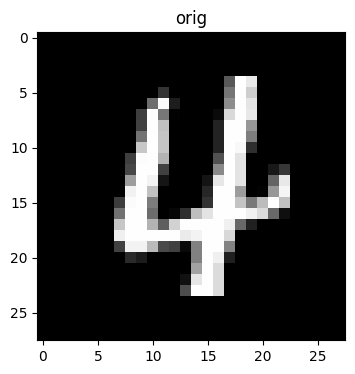

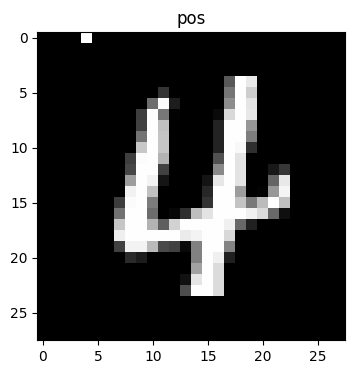

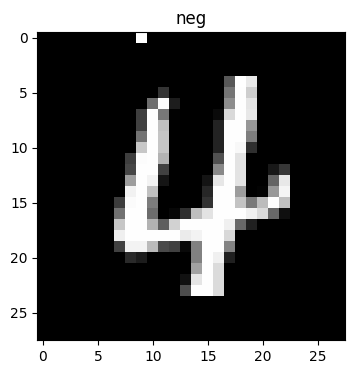

In [7]:
torch.manual_seed(123)
net = Net([784, 500, 500], "lif").to(device) # construct neural net with 784 input neurons, 500 neurons in each of the two hidden layers
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

x_pos = overlay_y_on_x(x, y)  # generate positive samples (i.e., correct labels overlayed on input data)

# generate negative samples (i.e., incorrect labels overlayed on input data)
rnd = torch.randperm(x.size(0))
x_neg = overlay_y_on_x(x, y[rnd])  # 

# visualize samples
for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
    visualize_sample(data, name)

### 4.3 Training the Network

In [8]:
loss = net.train(x_pos, x_neg)
print('Train error:', 100*(1.0 - net.predict(x).eq(y).float().mean().item()),'%')

Training layer 0 ...


fTraining LeakyLayer: 100%|██████████| 1000/1000 [00:02<00:00, 440.80it/s]


Training layer 1 ...


fTraining LeakyLayer: 100%|██████████| 1000/1000 [00:02<00:00, 386.92it/s]


Train error: 42.1875 %


## 5. Testing the Network

In [9]:
x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.to(device), y_te.to(device)

print('Test error:', 100*(1.0 - net.predict(x_te).eq(y_te).float().mean().item()), '%')

Test error: 70.3125 %


It's not great, but running more time-steps of simulations across more epochs should help. Give it a go.

## 6. Plotting the Loss of Each Layer

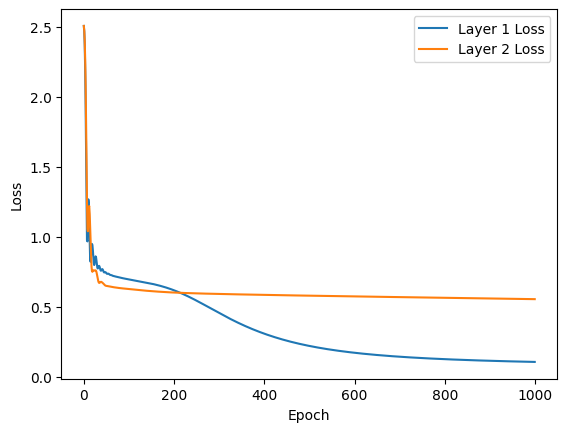

In [10]:
plt.plot(loss[0,:], label="Layer 1 Loss")
plt.plot(loss[1,:], label="Layer 2 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Train the Network using ReLU instead of LIF Activation

*   To compare, we can also train and test the same network architecture on the same data, except now using ReLU as the activation function instead of LIF.
*   Running this cell provides a training error and a test error of approximately 10% each.




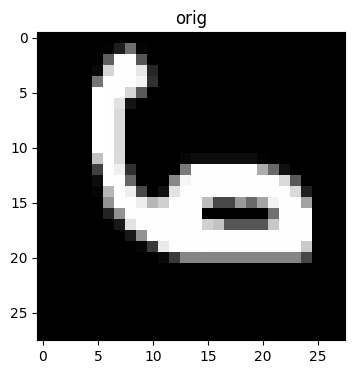

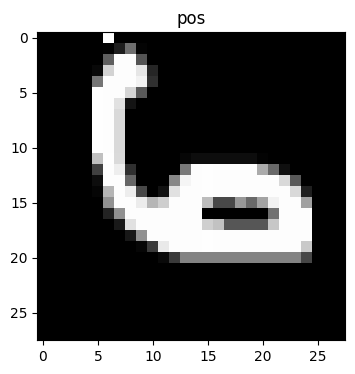

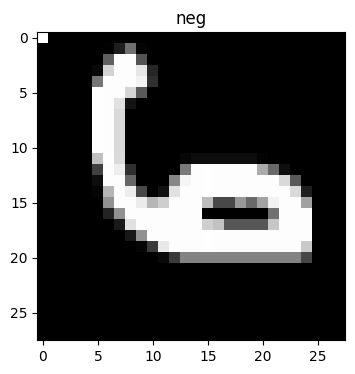

Training layer 0 ...


fTraining LeakyLayer: 100%|██████████| 1000/1000 [00:01<00:00, 694.31it/s]


Training layer 1 ...


fTraining LeakyLayer: 100%|██████████| 1000/1000 [00:01<00:00, 701.83it/s]


train error: 39.0625 %
test error: 56.25 %


In [11]:
net = Net([784, 500, 500], "relu").to(device)

# load training data
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

# overlay labels on data
x_pos = overlay_y_on_x(x, y)
rnd = torch.randperm(x.size(0))
x_neg = overlay_y_on_x(x, y[rnd])

# visaualize samples
for data, name in zip([x, x_pos, x_neg], ['orig', 'pos', 'neg']):
    visualize_sample(data, name)

net.train(x_pos, x_neg)
print('train error:', 100*(1.0 - net.predict(x).eq(y).float().mean().item()),'%')

# load test data
x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.to(device), y_te.to(device)
print('test error:', 100*(1.0 - net.predict(x_te).eq(y_te).float().mean().item()),'%')

# Comparison against ANNs and SNNs using Backpropagation
As shown in [this Keras example](https://www.tensorflow.org/datasets/keras_example), a standard artificial neural network using backpropagation with similar architecure and hyperparameters can attain a test set error of about 2.50%.

As shown in [the snnTorch Tutorial 5 documentation](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html), a spiking neural network using backpropagation with the same architecture and similar set hyperparameters attains a test set error of about 6.13%.

See if you can modify the code to bridge that gap.

# References
> <cite> [Geoffrey Hinton. The Forward-Forward Algorithm: Some Preliminary
Investigations. 2022. arXiv: 2212.13345 [cs.LG].](https://arxiv.org/abs/2212.13345) </cite>

> <cite> [Mohammad Pezeshki. pytorch_forward_forward. Github Repo January 2023.](https://github.com/mpezeshki/pytorch_forward_forward) </cite>